# Run ensemble Summa model on HPC

Structure for Unifying Multiple Modeling Alternative [(SUMMA)](https://ral.ucar.edu/projects/summa) is a hydrologic modeling approach that is built on a common set of conservation equations and a common numerical solver, which together constitute the structural core of the model. Different modeling approaches can then be implemented within the structural core, enabling a controlled and systematic analysis of alternative modeling options, and providing insight for future model development.

This notebook demonstrates how to harmonize different libraries and tools provided in the CyberGIS-Jupyter environment to run a 75-member ensemble SUMMA model with a High Performance Computer (HPC) resource. The SUMMA model instance and data used in this notebook were adapted from a part of the Clark et al., (2015) study, and explored the impact of different stomatal resistance parameterizations on total evapotranspiration (ET) in the Reynolds Mountain East catchment in southwestern Idaho.

Clark, M. P., B. Nijssen, J. Lundquist, D. Kavetski, D. Rupp, R. Woods, E. Gutmann, A. Wood, D. Gochis, R. Rasmussen, D. Tarboton, V. Mahat, G. Flerchinger, and D. Marks, 2015: A unified approach for process-based hydrologic modeling: Part 2. Model implementation and example applications. Water Resources Research, 51, doi: 10.1002/2015WR017200


# Notebook Outline
- [Retrieve Resources](#resources)
- [Unzip model instance package](#unzip)
- [Install SUMMA model](#install)
- [Use PySumma to build ensembles](#build)
- [Submit model](#submit)
- [Check model output](#check)
- [Plot the output](#plot)
    - [Leaf Area Index & ET](#LAI)
    - [stomatal resistance & ET](#stomatal)
- [Cleanup](#cleanup)

<a id='resources'></a>
## Retrieve a Summa model instance resource from HydroShare

### [For more info on this resource](https://www.hydroshare.org/resource/1f3f310af8364d2aa3e6a9459152a21c/)

In [1]:
resource_id = '1f3f310af8364d2aa3e6a9459152a21c'

In [2]:
import json
import os
from hs_restclient import HydroShare, HydroShareAuthBasic
auth = HydroShareAuthBasic("cybergis", "demo")
hs = HydroShare(auth=auth)
base_dir = os.path.abspath('/home/jovyan/work')
download_dir = os.path.join(base_dir, 'Downloads')
!mkdir -p {download_dir}
hs.getResource(resource_id, destination=download_dir, unzip=True)

<a id='unzip'></a>
## Unzip model instance package

In [3]:
import os
#Unzip model file
model_folder_name = "SummaModel_ReynoldsAspenStand_StomatalResistance_sopron"
content_folder = os.path.join(download_dir ,"{}/{}/data/contents".format(resource_id, resource_id))
file_manger_rel_path = "settings/summa_fileManager_riparianAspenSimpleResistance.txt"
import tempfile
workspace_dir = os.path.join(base_dir, 'workspace')
!mkdir -p {workspace_dir}
unzip_dir = tempfile.mkdtemp(dir=workspace_dir)
!cd {content_folder} && unzip -o {model_folder_name}.zip -d {unzip_dir}
print("Unzipping Done")

Archive:  SummaModel_ReynoldsAspenStand_StomatalResistance_sopron.zip
   creating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/
   creating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/
   creating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/
  inflating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc  
  inflating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson  
   creating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/
  inflating: /home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFl

<a id='install'></a>
## "Install" SUMMA model on Jupyter server (fix broken path in summa file_manager)

In [4]:
model_source_folder_path = os.path.join(unzip_dir, model_folder_name)
!cd {model_source_folder_path} && chmod +x ./installTestCases_local.sh
!cd {model_source_folder_path} && ./installTestCases_local.sh

TestCases installed


<a id='build'></a>
## Use PySumma to build ensembles

In [5]:
# Create a empty ParamTrial.nc file (required by parameter ensemble)
import netCDF4 as nc
name = os.path.join(model_source_folder_path, 'settings/summa_zParamTrial_riparianAspen.nc')
print(name)
param_trial = nc.Dataset(name, "w", format="NETCDF3_CLASSIC")
param_trial.createDimension("hru", 1)
param_trial.close()

/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/settings/summa_zParamTrial_riparianAspen.nc


In [6]:
import numpy as np
import json
from pysumma import ensemble

def safe_arange(start, stop, step):
    a = np.arange(start, stop, step)
    result =[]
    for i in a:
        par = round(i, 10)
        result = np.append(result, par)
    return result

# create ensemble
# different parameterizations
decision_options = {
    "stomResist": ["BallBerry", "Jarvis", "simpleResistance"]
}
# different parameters
param_options = {
   'rootDistExp': safe_arange(0.01, 1.00, 0.20),
   'summerLAI': safe_arange(0.01, 10.00, 2.00)
}

config = ensemble.total_product(dec_conf=decision_options, param_conf=param_options)

# save ensemble info to json file
with open(os.path.join(model_source_folder_path, 'summa_options.json'), 'w') as outfile:
    json.dump(config, outfile)

# check ensemble parameters    
print("Number of ensemble runs: {}".format(len(config)))
print(json.dumps(config, indent=4, sort_keys=True)[:800])
print("...")

Number of ensemble runs: 75
{
    "++BallBerry++rootDistExp=0.01++summerLAI=0.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 0.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=2.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 2.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=4.01++": {
        "decisions": {
            "stomResist": "BallBerry"
        },
        "parameters": {
            "rootDistExp": 0.01,
            "summerLAI": 4.01
        }
    },
    "++BallBerry++rootDistExp=0.01++summerLAI=6.01++": {
        "decisions": {
            "stomRe
...


<a id='submit'></a>
## Submit model to XSEDE Comet HPC using CyberGIS-Jupyter tool

In [7]:
from cybergis import summaUI

s = summaUI(model_source_folder_path, file_manger_rel_path, 
            workspace_dir)

In [8]:
s.runSumma()

2019-12-17 23:46:37,018 [MainThread  ] [INFO ]  SSH logged into keeling.earth.illinois.edu as user cigi-gisolve
2019-12-17 23:46:37,026 [MainThread  ] [INFO ]  Uploading /home/jovyan/work/workspace/Summa_1576626391_cca51dbf to /data/keeling/a/cigi-gisolve
2019-12-17 23:46:40,843 [MainThread  ] [INFO ]  Submitting Job summa.sbatch to queue
2019-12-17 23:46:41,160 [MainThread  ] [INFO ]  Remote Job ID assigned: 3461002
2019-12-17 23:46:44,611 [MainThread  ] [INFO ]  R
2019-12-17 23:46:48,052 [MainThread  ] [INFO ]  R
2019-12-17 23:46:53,090 [MainThread  ] [INFO ]  R
2019-12-17 23:46:56,947 [MainThread  ] [INFO ]  R
2019-12-17 23:47:00,388 [MainThread  ] [INFO ]  R
2019-12-17 23:47:03,829 [MainThread  ] [INFO ]  R
2019-12-17 23:47:07,266 [MainThread  ] [INFO ]  R
2019-12-17 23:47:10,730 [MainThread  ] [INFO ]  R
2019-12-17 23:47:14,243 [MainThread  ] [INFO ]  R
2019-12-17 23:47:17,700 [MainThread  ] [INFO ]  R
2019-12-17 23:47:21,231 [MainThread  ] [INFO ]  R
2019-12-17 23:47:24,732 [Main

<a id='check'></a>
## Check model output  -- NetCDF files

In [9]:
# check output directory
job_dir = os.path.join(workspace_dir, "{}".format(s.job_local_id))
output_path = os.path.join(job_dir, "output")
# check SUMMA output file 
name_list = os.listdir(output_path)
full_list = [os.path.join(output_path,i) for i in name_list if i.endswith(".nc")]
sorted_list = sorted(full_list)

for f in sorted_list:
    print(f)
print("Number of NC files: {}".format(len(sorted_list)))

/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=0.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=2.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=4.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=6.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=8.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.21++summerLAI=0.01++_timestep.nc
/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp

<a id='plot'></a>
## Plot time series for total evapotranspiration (total ET)

In [10]:
%matplotlib inline
import os
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
import numpy as np

def calc_total_et(et_output_df):
    # Total Evapotranspiration = Canopy Transpiration + Canopy Evaporation + Ground Evaporation
    # Change unit from kgm-2s-1 to mm/hr (mulpitle 3600)
    total_et_data = (et_output_df['scalarCanopyTranspiration'] + et_output_df['scalarCanopyEvaporation'] + et_output_df['scalarGroundEvaporation'])*3600
    # create dates(X-axis) attribute from ouput netcdf
    dates = total_et_data.coords['time'].data
    # create data value(Y-axis) attribute from ouput netcdf
    data_values = total_et_data.data
    # create two dimensional tabular data structure 
    total_et_df = pd.DataFrame(data_values, index=dates)
    # round time to nearest hour (ex. 2006-10-01T00:59:59.99 -> 2006-10-01T01:00:00)
    total_et_df.index = total_et_df.index.round("H")
    # set the time period to display plot 
    total_et_df = total_et_df.loc["2006-07-01":"2007-08-20"]
    # resample data by the average value hourly
    total_et_df_hourly = total_et_df.resample("H").mean()
    # resample data by the average for hour of day
    total_et_by_hour = total_et_df_hourly.groupby(total_et_df_hourly.index.hour).mean()
    return total_et_by_hour

def plot_ET(nc_list):
    
    dataset_list = [calc_total_et(xr.open_dataset(nc)) for nc in nc_list]
    ET_Combine = pd.concat(dataset_list, axis=1)
    ET_Combine_Graph = ET_Combine.plot()
    # invert y axis
    ET_Combine_Graph.invert_yaxis()

    # add x, y label
    ET_Combine_Graph.set(xlabel='Time of day (hr)', ylabel='Total evapotranspiration (mm h-1) ')
    # show up the legend
    legend = []
    for nc in nc_list:
        legend.append(os.path.basename(nc))
    ET_Combine_Graph.legend(legend, loc='center left', bbox_to_anchor=(1.0, 0.5))
    jtplot.figsize(x=10, y=10)

<a id='LAI'></a>
### How do different  Leaf Area Index (summerLAI) values affect total ET?

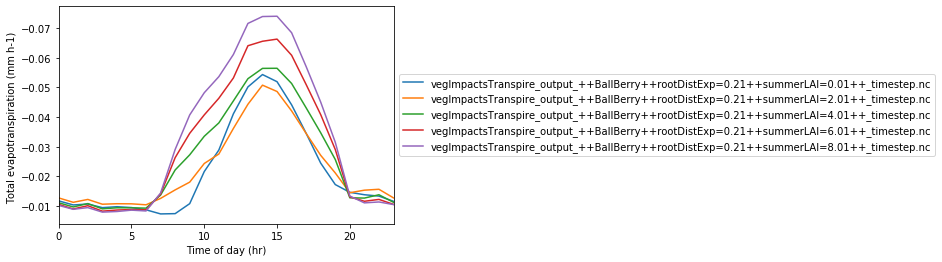

In [11]:
subset = [x for x in sorted_list if 'BallBerry++rootDistExp=0.21' in x]
plot_ET(subset)

<a id='stomatal'></a>
### How do different  stomatal resistance parameterizations affect total ET?

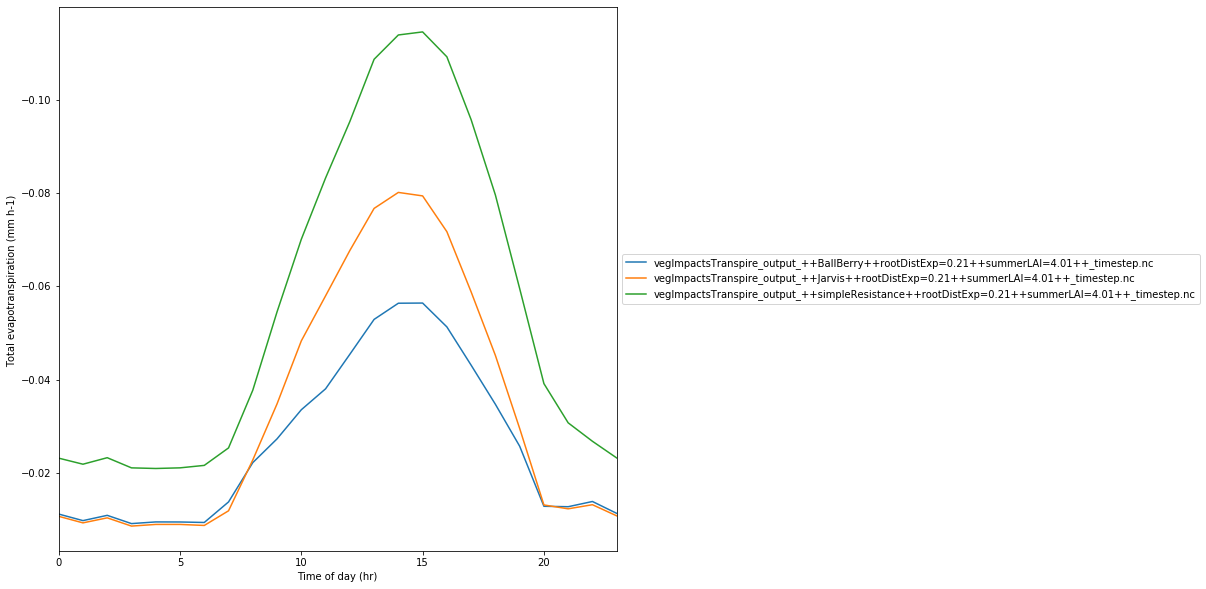

In [12]:
subset = [x for x in sorted_list if 'rootDistExp=0.21++summerLAI=4.01' in x]
plot_ET(subset)

<a id='cleanup'></a>
## Cleanup

In [13]:
! rm -rvf {unzip_dir} {job_dir}

removed '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData/forcing_above_aspen.nc'
removed directory '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/forcingData'
removed '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/reynolds_geojson_latlon.geojson'
removed '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData/ReynoldsCreek_eddyFlux.nc'
removed directory '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data/validationData'
removed directory '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/data'
removed '/home/jovyan/work/workspace/tmps21kw6w3/SummaModel_ReynoldsAspenStand_StomatalResistance_sopron/installTestCases_local.sh'
removed directory '/home/jovyan/work/

removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.01++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.21++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++simpleResistance++rootDistExp=0.61++summerLAI=4.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.81++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.01++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.21++summerLAI=0.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_

removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++Jarvis++rootDistExp=0.81++summerLAI=8.01++_timestep.nc'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output/vegImpactsTranspire_output_++BallBerry++rootDistExp=0.21++summerLAI=8.01++_timestep.nc'
removed directory '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/output'
removed '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf/slurm-3461002.out'
removed directory '/home/jovyan/work/workspace/Summa_1576626391_cca51dbf'


# Done